# 项目需求：通过XGboost来实现预测zclose值

# 导入各python包

In [2789]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')
import joblib
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from keras.callbacks import EarlyStopping, ModelCheckpoint

# 导入数据

In [2790]:
all_data_set_path = r'https://raw.githubusercontent.com/Daming8/ST/main/CSI300ALL.csv'
all_data_set = pd.read_csv(all_data_set_path)

In [2791]:
print(all_data_set.head())

        Date      Open      High       Low     Close  Adj Close       Volume  \
0   2010/1/7  3543.160  3558.556  3452.769  3471.456   3471.456   8035003700   
1   2010/1/8  3456.908  3482.083  3426.698  3480.130   3480.130   6079025300   
2  2010/1/11  3593.106  3594.528  3465.317  3482.052   3482.052   8998017200   
3  2010/1/12  3477.842  3535.407  3437.661  3534.916   3534.916   9374327800   
4  2010/1/13  3448.291  3490.112  3415.693  3421.144   3421.144  11245790100   

         Amount    PctChg  EPS(TTM)  ...      rsv_9     kdjk_9       kdjk  \
0  1.200000e+11 -1.984089    125.24  ...  12.889453  33.782042  33.782042   
1  9.019096e+10  0.249861    125.62  ...  31.237650  32.933911  32.933911   
2  1.340000e+11  0.055231    125.15  ...  32.361298  32.743040  32.743040   
3  1.340000e+11  1.518186    124.90  ...  63.266881  42.917654  42.917654   
4  1.600000e+11 -3.218520    125.65  ...   2.994150  29.609819  29.609819   

      kdjd_9       kdjd     kdjj_9       kdjj         bo

In [2792]:
print(all_data_set.info()) #查看有多少数据及特征

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3155 entries, 0 to 3154
Data columns (total 51 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Date                              3155 non-null   object 
 1   Open                              3155 non-null   float64
 2   High                              3155 non-null   float64
 3   Low                               3155 non-null   float64
 4   Close                             3155 non-null   float64
 5   Adj Close                         3155 non-null   float64
 6   Volume                            3155 non-null   int64  
 7   Amount                            3155 non-null   float64
 8   PctChg                            3155 non-null   float64
 9   EPS(TTM)                          3155 non-null   float64
 10  PE(TTM)                           3155 non-null   float64
 11  50.79x/interval maximum           3155 non-null   float64
 12  40.10x

In [2793]:
print(all_data_set.isnull().sum()) #检查是否有空数据

Date                                0
Open                                0
High                                0
Low                                 0
Close                               0
Adj Close                           0
Volume                              0
Amount                              0
PctChg                              0
EPS(TTM)                            0
PE(TTM)                             0
50.79x/interval maximum             0
40.10x/75% quantile                 0
29.40x/50% quantile                 0
18.71x/25% quantile                 0
8.02x/interval min.                 0
BPS(MRQ)                            0
PB(MRQ)                             0
7.58x/interval maximum              0
5.98x/75% quantile                  0
4.37x/50% quantile                  0
2.77x/25% quantile                  0
1.17x/interval min.                 0
Operating income per share (TTM)    0
PS(TTM)                             0
5.27x/interval maximum              0
4.16x/75% qu

# 研究数据

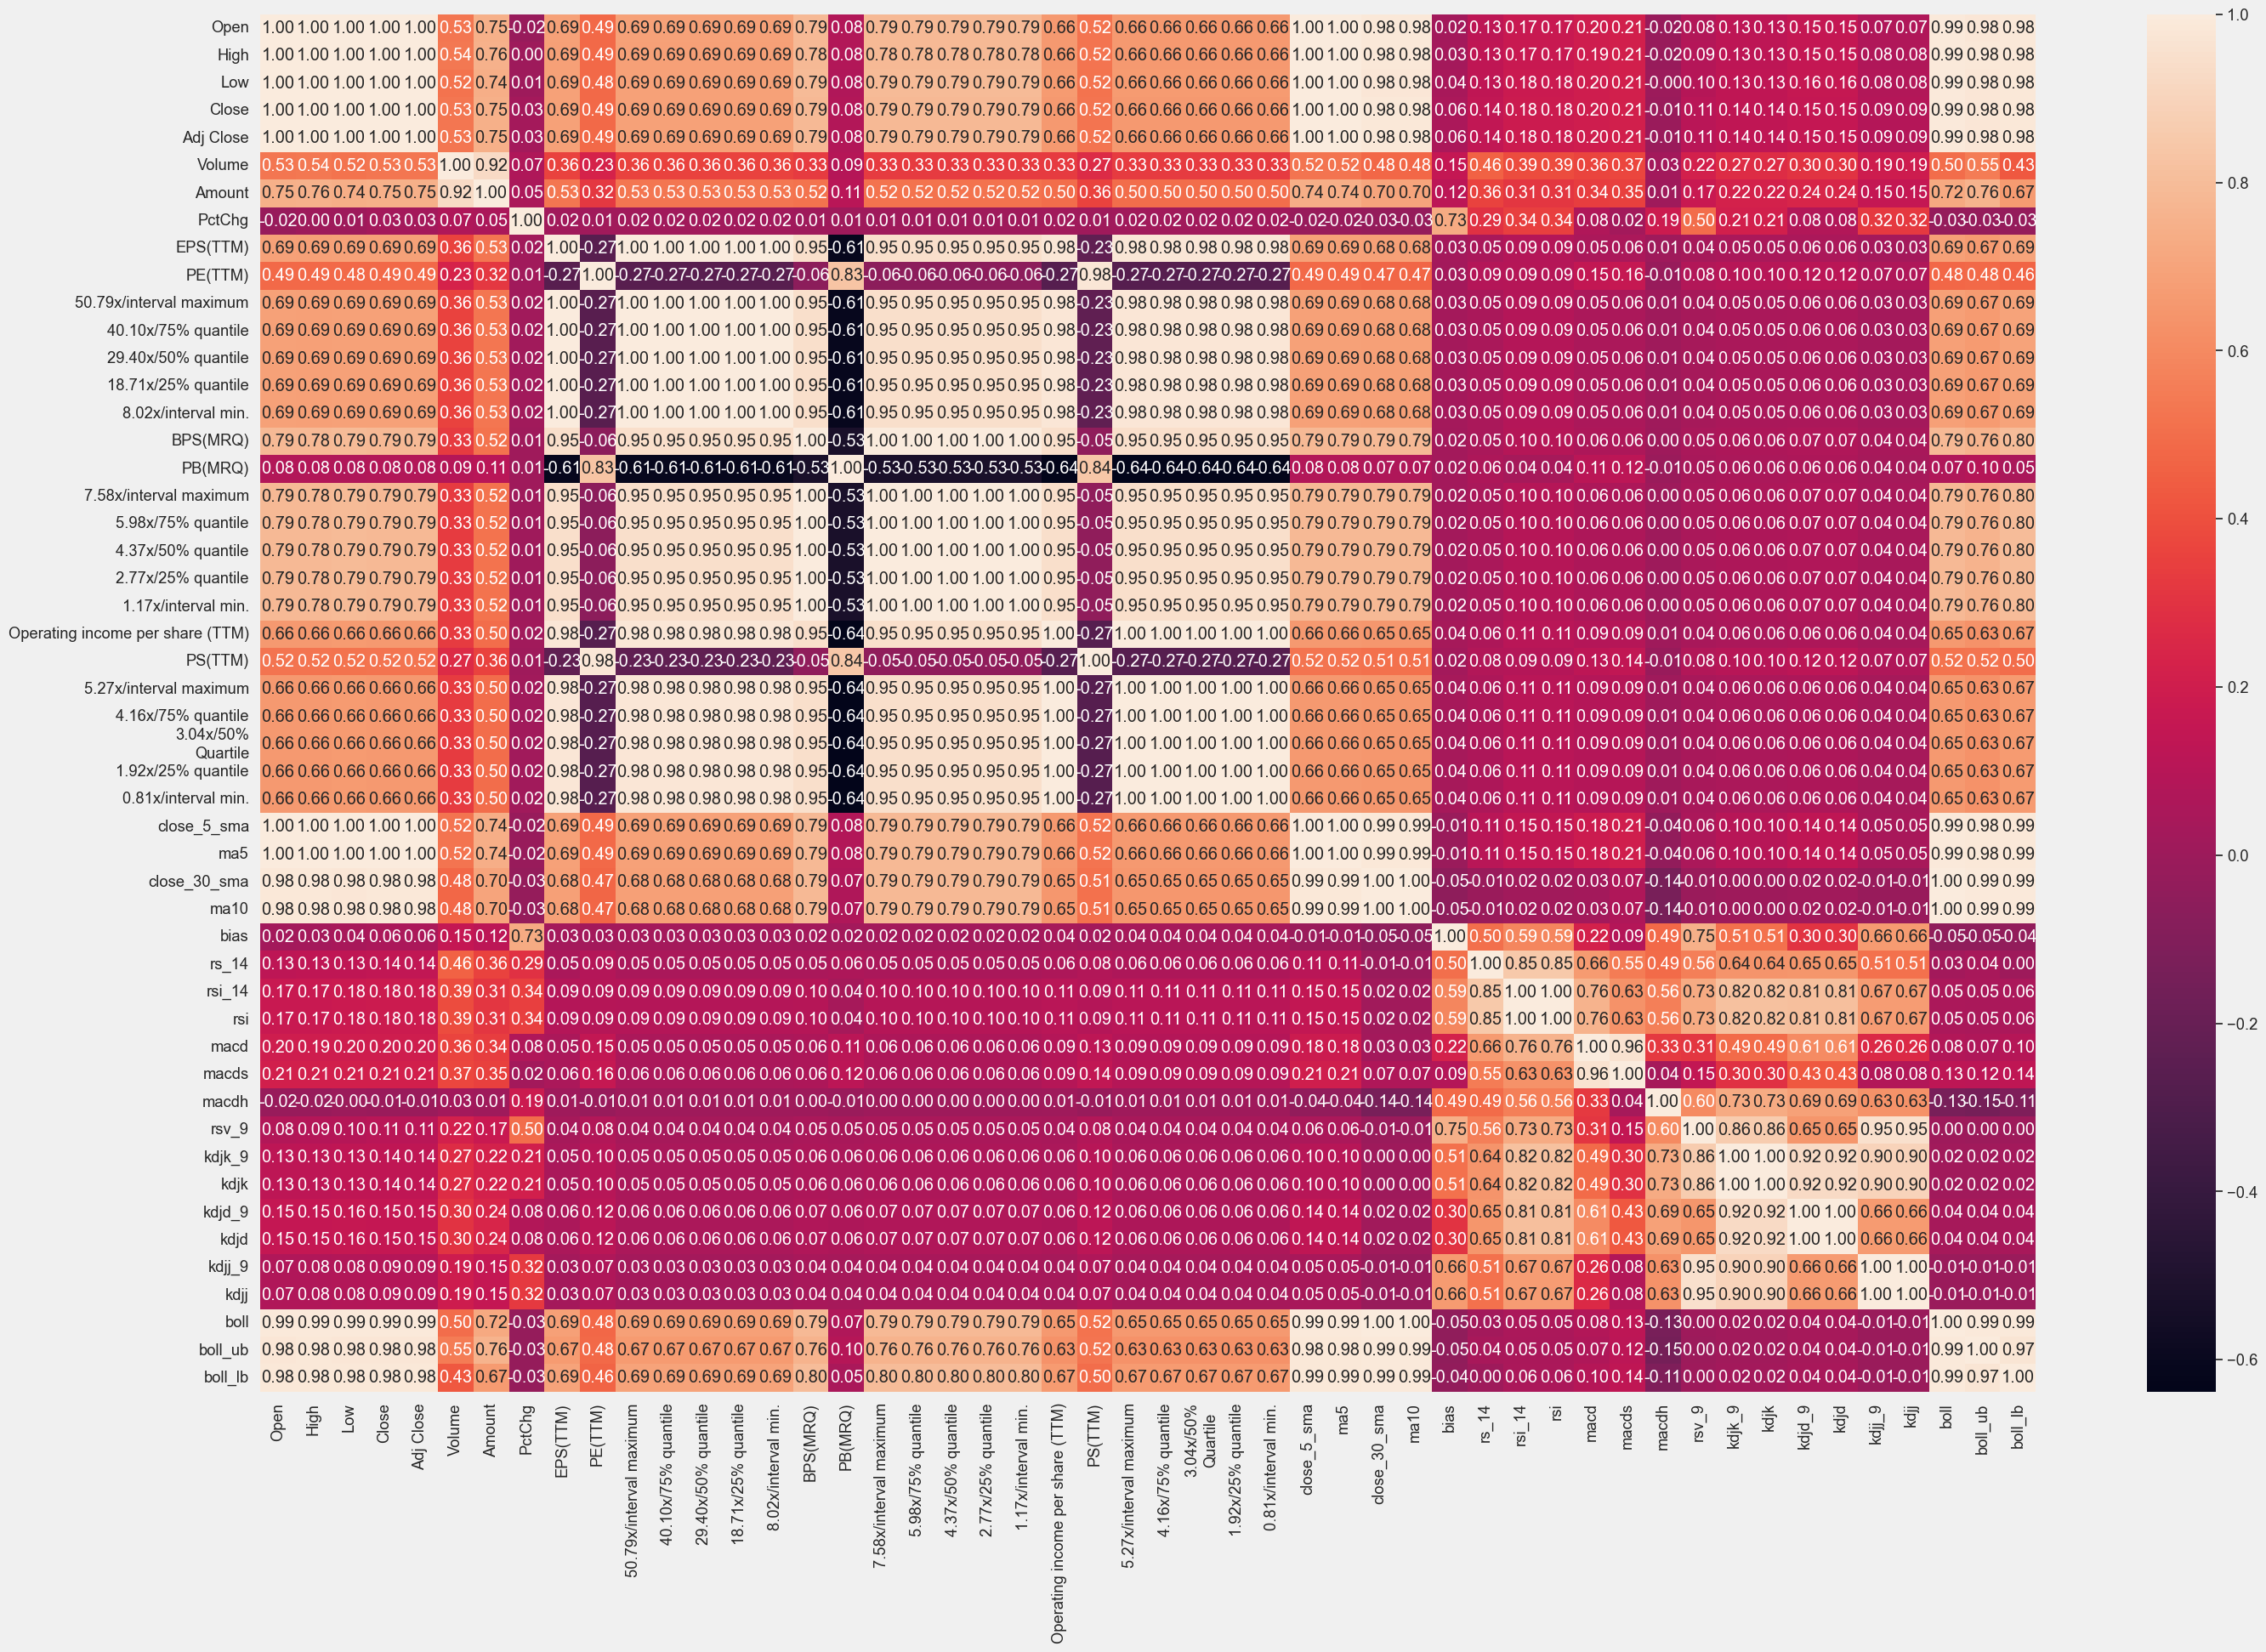

In [2794]:
# 特征热力图 相关性分析
list_columns = all_data_set.columns
plt.figure(figsize=(30,20))
sns.set(font_scale=1.2)
sns.heatmap(all_data_set[list_columns].corr(), annot=True, fmt=".2f")
plt.show()

In [2795]:
# 对特征重要性进行排序
corr_1 = all_data_set.corr()
corr_1["Close"].sort_values(ascending=False)

Close                               1.000000
Adj Close                           1.000000
High                                0.999286
Low                                 0.999262
Open                                0.998548
ma5                                 0.997766
close_5_sma                         0.997766
boll                                0.988058
boll_lb                             0.982233
ma10                                0.981147
close_30_sma                        0.981147
boll_ub                             0.978231
BPS(MRQ)                            0.787156
5.98x/75% quantile                  0.787156
7.58x/interval maximum              0.787156
4.37x/50% quantile                  0.787156
1.17x/interval min.                 0.787156
2.77x/25% quantile                  0.787156
Amount                              0.748469
EPS(TTM)                            0.687916
8.02x/interval min.                 0.687916
29.40x/50% quantile                 0.687916
50.79x/int

# 数据预处理

In [2796]:
len_ = len(['Open','High','Low','Close'])*3
col_numbers_drop = []
for i in range(3):
    col_numbers_drop.append(len_+i)
print(col_numbers_drop)

[12, 13, 14]


In [2797]:
all_data_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3155 entries, 0 to 3154
Data columns (total 51 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Date                              3155 non-null   object 
 1   Open                              3155 non-null   float64
 2   High                              3155 non-null   float64
 3   Low                               3155 non-null   float64
 4   Close                             3155 non-null   float64
 5   Adj Close                         3155 non-null   float64
 6   Volume                            3155 non-null   int64  
 7   Amount                            3155 non-null   float64
 8   PctChg                            3155 non-null   float64
 9   EPS(TTM)                          3155 non-null   float64
 10  PE(TTM)                           3155 non-null   float64
 11  50.79x/interval maximum           3155 non-null   float64
 12  40.10x

In [2798]:
# 依据特征重要性，选择zlow zhigh zopen来进行预测zclose
# 数据选择t-n, ...., t-2 t-1 与 t 来预测未来 t+1
# 转换原始数据为新的特征列来进行预测,time_window可以用来调试用前几次的数据来预测
def series_to_supervised(data,time_window=3):
    data_columns = ['Open','High','Low','Close']
    data = data[data_columns]  # Note this is important to the important feature choice
    cols, names = list(), list()
    for i in range(time_window, -1, -1):
        # get the data
        cols.append(data.shift(i)) #数据偏移量
        
        # get the column name
        if ((i-1)<=0):
            suffix = '(t+%d)'%abs(i-1)
        else:
            suffix = '(t-%d)'%(i-1)
        names += [(colname + suffix) for colname in data_columns]
        
    # concat the cols into one dataframe
    agg = pd.concat(cols,axis=1)
    agg.columns = names
    agg.index = data.index.copy()
    # remove the nan value which is caused by pandas.shift
    agg = agg.dropna(inplace=False)

    # remove unused col (only keep the "close" fied for the t+1 period)
    # Note col "close" place in the columns

    len_ = len(data_columns)*time_window
    col_numbers_drop = []
    for i in range(len(data_columns)-1):
        col_numbers_drop.append(len_+i)

    agg.drop(agg.columns[col_numbers_drop],axis=1,inplace = True)
       
    return agg
    

In [2799]:
all_data_set2 = all_data_set.copy()
all_data_set2["Date"] = pd.to_datetime(all_data_set2["Date"])       # 日期object: to datetime
all_data_set2.set_index("Date", inplace=True, drop=True) # 把index设为索引

In [2800]:
all_data_set2 = all_data_set2[116:] # 这里把7月28日的数据全部删掉了，主要是数据缺失较多

In [2801]:
data_set_process = series_to_supervised(all_data_set2,10) #取近10分钟的数据
print(data_set_process.columns.values)

['Open(t-9)' 'High(t-9)' 'Low(t-9)' 'Close(t-9)' 'Open(t-8)' 'High(t-8)'
 'Low(t-8)' 'Close(t-8)' 'Open(t-7)' 'High(t-7)' 'Low(t-7)' 'Close(t-7)'
 'Open(t-6)' 'High(t-6)' 'Low(t-6)' 'Close(t-6)' 'Open(t-5)' 'High(t-5)'
 'Low(t-5)' 'Close(t-5)' 'Open(t-4)' 'High(t-4)' 'Low(t-4)' 'Close(t-4)'
 'Open(t-3)' 'High(t-3)' 'Low(t-3)' 'Close(t-3)' 'Open(t-2)' 'High(t-2)'
 'Low(t-2)' 'Close(t-2)' 'Open(t-1)' 'High(t-1)' 'Low(t-1)' 'Close(t-1)'
 'Open(t+0)' 'High(t+0)' 'Low(t+0)' 'Close(t+0)' 'Close(t+1)']


In [2802]:
print(data_set_process.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3029 entries, 2010-07-16 to 2022-12-30
Data columns (total 41 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Open(t-9)   3029 non-null   float64
 1   High(t-9)   3029 non-null   float64
 2   Low(t-9)    3029 non-null   float64
 3   Close(t-9)  3029 non-null   float64
 4   Open(t-8)   3029 non-null   float64
 5   High(t-8)   3029 non-null   float64
 6   Low(t-8)    3029 non-null   float64
 7   Close(t-8)  3029 non-null   float64
 8   Open(t-7)   3029 non-null   float64
 9   High(t-7)   3029 non-null   float64
 10  Low(t-7)    3029 non-null   float64
 11  Close(t-7)  3029 non-null   float64
 12  Open(t-6)   3029 non-null   float64
 13  High(t-6)   3029 non-null   float64
 14  Low(t-6)    3029 non-null   float64
 15  Close(t-6)  3029 non-null   float64
 16  Open(t-5)   3029 non-null   float64
 17  High(t-5)   3029 non-null   float64
 18  Low(t-5)    3029 non-null   float64
 19  Close(t-5

In [2803]:
print(data_set_process.head())

            Open(t-9)  High(t-9)  Low(t-9)  Close(t-9)  Open(t-8)  High(t-8)  \
Date                                                                           
2010-07-16   2523.035   2542.122  2462.202    2534.105   2507.354   2529.425   
2010-07-19   2507.354   2529.425  2476.490    2512.651   2504.869   2563.411   
2010-07-20   2504.869   2563.411  2502.931    2562.902   2561.106   2580.608   
2010-07-21   2561.106   2580.608  2548.559    2580.477   2591.509   2602.230   
2010-07-22   2591.509   2602.230  2564.638    2575.921   2578.555   2662.163   

            Low(t-8)  Close(t-8)  Open(t-7)  High(t-7)  ...  Close(t-2)  \
Date                                                    ...               
2010-07-16  2476.490    2512.651   2504.869   2563.411  ...    2634.593   
2010-07-19  2502.931    2562.902   2561.106   2580.608  ...    2653.609   
2010-07-20  2548.559    2580.477   2591.509   2602.230  ...    2608.519   
2010-07-21  2564.638    2575.921   2578.555   2662.163  ...    2

# 搭建模型XGboost

In [2804]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data_set_process)

In [2805]:
train_size = int(len(data_set_process)*0.8)
test_size = len(data_set_process) - train_size
train_XGB, test_XGB = scaled_data[0:train_size,:],scaled_data[train_size:len(data_set_process),:]

train_XGB_X, train_XGB_Y = train_XGB[:,:(len(data_set_process.columns)-1)],train_XGB[:,(len(data_set_process.columns)-1)]
test_XGB_X, test_XGB_Y = test_XGB[:,:(len(data_set_process.columns)-1)],test_XGB[:,(len(data_set_process.columns)-1)]


In [2806]:
test_XGB_Y[0:10]

array([0.72217582, 0.74012031, 0.7165665 , 0.74339653, 0.7309606 ,
       0.71423777, 0.65290192, 0.66054755, 0.69699285, 0.6998788 ])

In [2807]:
# 算法参数
params = {
    'booster':'gbtree',
    'objective':'binary:logistic',  # 此处为回归预测，这里如果改成multi:softmax 则可以进行多分类
    'gamma':0.1,
    'max_depth':4,
    'lambda':2,
    'subsample':0.8,
    'colsample_bytree':0.6,
    'min_child_weight':2,
    'slient':1,
    'eta':0.15,
    'seed':1000,
    'nthread':8,
}

In [2808]:
#生成数据集格式
xgb_train = xgb.DMatrix(train_XGB_X,label = train_XGB_Y)
xgb_test = xgb.DMatrix(test_XGB_X,label = test_XGB_Y)
num_rounds = 300
watchlist = [(xgb_test,'eval'),(xgb_train,'train')]

In [2809]:
#xgboost模型训练
model_xgb = xgb.train(params,xgb_train,num_rounds,watchlist)

[22:47:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "slient" } are not used.

[0]	eval-logloss:0.67447	train-logloss:0.65428
[1]	eval-logloss:0.65726	train-logloss:0.62539
[2]	eval-logloss:0.64313	train-logloss:0.60350
[3]	eval-logloss:0.63270	train-logloss:0.58672
[4]	eval-logloss:0.62355	train-logloss:0.57373
[5]	eval-logloss:0.61713	train-logloss:0.56355
[6]	eval-logloss:0.61164	train-logloss:0.55556
[7]	eval-logloss:0.60656	train-logloss:0.54928
[8]	eval-logloss:0.60197	train-logloss:0.54435
[9]	eval-logloss:0.59829	train-logloss:0.54041
[10]	eval-logloss:0.59574	train-logloss:0.53728
[11]	eval-logloss:0.59342	train-logloss:0.53481
[12]	eval-logloss:0.59149	train-logloss:0.53284
[13]	eval-logloss:0.59010	train-logloss:0.53129
[14]	eval-logloss:0.58859	train-logloss:0.53005
[15]	eval-logloss:0.58739	train-logloss:0.52906
[16]	eval-logloss:0.58634	train-logloss:0.5282

c:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[58]	eval-logloss:0.58124	train-logloss:0.52511
[59]	eval-logloss:0.58124	train-logloss:0.52511
[60]	eval-logloss:0.58124	train-logloss:0.52511
[61]	eval-logloss:0.58124	train-logloss:0.52511
[62]	eval-logloss:0.58124	train-logloss:0.52511
[63]	eval-logloss:0.58124	train-logloss:0.52511
[64]	eval-logloss:0.58124	train-logloss:0.52511
[65]	eval-logloss:0.58124	train-logloss:0.52511
[66]	eval-logloss:0.58124	train-logloss:0.52511
[67]	eval-logloss:0.58124	train-logloss:0.52511
[68]	eval-logloss:0.58124	train-logloss:0.52511
[69]	eval-logloss:0.58124	train-logloss:0.52511
[70]	eval-logloss:0.58124	train-logloss:0.52511
[71]	eval-logloss:0.58124	train-logloss:0.52511
[72]	eval-logloss:0.58124	train-logloss:0.52511
[73]	eval-logloss:0.58124	train-logloss:0.52511
[74]	eval-logloss:0.58124	train-logloss:0.52511
[75]	eval-logloss:0.58124	train-logloss:0.52511
[76]	eval-logloss:0.58124	train-logloss:0.52511
[77]	eval-logloss:0.58124	train-logloss:0.52511
[78]	eval-logloss:0.58124	train-logloss:

In [2810]:
#对测试集进行预测
y_pred_xgb = model_xgb.predict(xgb_test)

In [2811]:
y_pred_xgb.shape

(606,)

In [2812]:
y_pred_xgb

array([0.69183975, 0.707126  , 0.7311694 , 0.707126  , 0.72700214,
       0.707126  , 0.7166458 , 0.68756807, 0.67640084, 0.6892618 ,
       0.6892618 , 0.7001819 , 0.7001819 , 0.67640084, 0.67640084,
       0.67640084, 0.6892618 , 0.6892618 , 0.7001819 , 0.707126  ,
       0.7114767 , 0.707126  , 0.707126  , 0.7001819 , 0.7001819 ,
       0.7001819 , 0.6892618 , 0.6892618 , 0.6892618 , 0.707126  ,
       0.7114767 , 0.7001819 , 0.7001819 , 0.7001819 , 0.707126  ,
       0.7114767 , 0.7001819 , 0.7001819 , 0.72700214, 0.7114767 ,
       0.74019474, 0.7311694 , 0.7209108 , 0.7166458 , 0.7001819 ,
       0.6892618 , 0.67640084, 0.67640084, 0.6892618 , 0.6892618 ,
       0.6892618 , 0.6892618 , 0.6892618 , 0.7001819 , 0.7001819 ,
       0.6892618 , 0.6892618 , 0.67640084, 0.67640084, 0.67640084,
       0.67640084, 0.67640084, 0.6892618 , 0.7155787 , 0.7311694 ,
       0.7114767 , 0.7209108 , 0.7114767 , 0.7114767 , 0.707126  ,
       0.7114767 , 0.707126  , 0.7001819 , 0.6892618 , 0.68926

In [2813]:
test_XGB_Y

array([0.72217582, 0.74012031, 0.7165665 , 0.74339653, 0.7309606 ,
       0.71423777, 0.65290192, 0.66054755, 0.69699285, 0.6998788 ,
       0.70616863, 0.70562849, 0.65003621, 0.65617997, 0.66687877,
       0.69664437, 0.69050115, 0.70095484, 0.72145193, 0.72265911,
       0.72301025, 0.71915493, 0.70441651, 0.70897029, 0.69739037,
       0.68821505, 0.68500817, 0.70353029, 0.73325474, 0.73259097,
       0.71321908, 0.69668372, 0.70735056, 0.7172964 , 0.71893629,
       0.70393381, 0.71071064, 0.74105937, 0.7335206 , 0.74048344,
       0.74095772, 0.73375708, 0.7211585 , 0.69405341, 0.70077832,
       0.67126797, 0.67056617, 0.6827425 , 0.68913049, 0.69919079,
       0.69082576, 0.68420231, 0.7122543 , 0.69998243, 0.68502113,
       0.68947359, 0.66548338, 0.66735287, 0.67054763, 0.67320591,
       0.67202228, 0.69721769, 0.73538648, 0.7396983 , 0.73107131,
       0.72882284, 0.72692534, 0.71719933, 0.72740675, 0.72723507,
       0.72324558, 0.70725515, 0.69993077, 0.70209252, 0.71230

In [2814]:
test_XGB_Y.shape

(606,)

In [2815]:
# from sklearn.model_selection import RandomizedSearchCV
# from sklearn.metrics import make_scorer

# # 定义自定义评分指标
# def mape(y_true, y_pred):
#     return np.mean(np.abs((y_true - y_pred) / y_true))

# mape_scorer = make_scorer(mape, greater_is_better=False)

# # 定义参数空间
# param_dist = {
#     'booster': ['gbtree', 'gblinear', 'dart'],
#     'n_estimators': list(range(100, 1200, 100)),
#     'max_depth': list(range(3, 10)),
#     'min_child_weight': list(range(1, 6)),
#     'gamma': [i / 10.0 for i in range(0, 5)],
#     'subsample': [i / 10.0 for i in range(6, 10)],
#     'colsample_bytree': [i / 10.0 for i in range(6, 10)],
#     'reg_alpha': [1e-5, 1e-2, 0.1, 1, 100],
#     'reg_lambda': [1e-5, 1e-2, 0.1, 1, 100],
# }

# # 使用随机搜索交叉验证寻找最佳参数
# model = xgb.XGBRegressor()
# random_search = RandomizedSearchCV(model, param_distributions=param_dist,
#                                    n_iter=10, scoring=mape_scorer, cv=5, n_jobs=-1)
# random_search.fit(train_XGB_X, train_XGB_Y)

# # 输出最佳参数和评分
# print("Best parameters found: ")
# print(random_search.best_params_)
# print("Lowest MAPE found: ")
# print(np.abs(random_search.best_score_))


In [2816]:
# print("Best parameters found: ", grid_search.best_params_)

In [2817]:
mape_xgb = np.mean(np.abs(y_pred_xgb-test_XGB_Y)/test_XGB_Y)*100
print('XGBoost平均误差率为：{}%'.format(mape_xgb))  

XGBoost平均误差率为：2.9894907158395863%


In [2818]:
mae_xgb = mean_absolute_error(test_XGB_Y, y_pred_xgb)
mse_xgb = mean_squared_error(test_XGB_Y, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
r2_xgb = r2_score(test_XGB_Y, y_pred_xgb)

print('MAE: {:.4f}'.format(mae_xgb))
print('MSE: {:.4f}'.format(mse_xgb))
print('RMSE: {:.4f}'.format(rmse_xgb))
print('R^2: {:.4f}'.format(r2_xgb))

MAE: 0.0221
MSE: 0.0013
RMSE: 0.0366
R^2: 0.9242


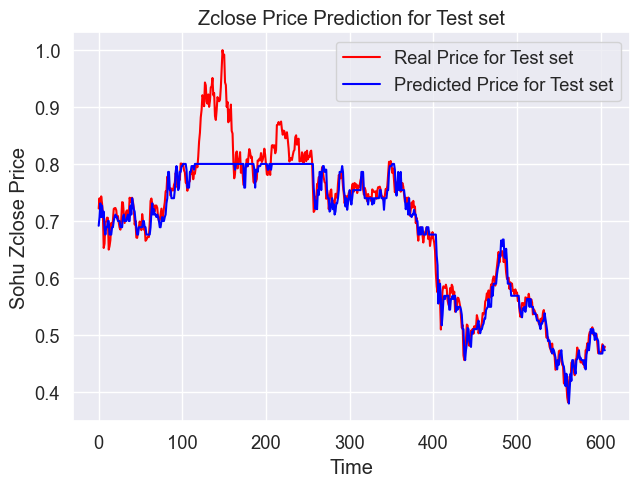

In [2819]:
plt.plot(test_XGB_Y, color = 'red', label = 'Real Price for Test set')
plt.plot(y_pred_xgb, color = 'blue', label = 'Predicted Price for Test set')
plt.title('Zclose Price Prediction for Test set')
plt.xlabel('Time')
plt.ylabel('Sohu Zclose Price')
plt.legend()
plt.show()

In [2820]:
joblib.dump(model_xgb, "XGBoost.pkl")

['XGBoost.pkl']

# 搭建模型LSTM网络

In [2821]:
# 注意这里要安装Tensorflow 和 Keras才能使用
from keras.models import Sequential
from keras.layers import Dense,LSTM

In [2822]:
data_set_process.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3029 entries, 2010-07-16 to 2022-12-30
Data columns (total 41 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Open(t-9)   3029 non-null   float64
 1   High(t-9)   3029 non-null   float64
 2   Low(t-9)    3029 non-null   float64
 3   Close(t-9)  3029 non-null   float64
 4   Open(t-8)   3029 non-null   float64
 5   High(t-8)   3029 non-null   float64
 6   Low(t-8)    3029 non-null   float64
 7   Close(t-8)  3029 non-null   float64
 8   Open(t-7)   3029 non-null   float64
 9   High(t-7)   3029 non-null   float64
 10  Low(t-7)    3029 non-null   float64
 11  Close(t-7)  3029 non-null   float64
 12  Open(t-6)   3029 non-null   float64
 13  High(t-6)   3029 non-null   float64
 14  Low(t-6)    3029 non-null   float64
 15  Close(t-6)  3029 non-null   float64
 16  Open(t-5)   3029 non-null   float64
 17  High(t-5)   3029 non-null   float64
 18  Low(t-5)    3029 non-null   float64
 19  Close(t-5

In [2823]:
len(data_set_process.columns)

41

In [2824]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data_set_process)

In [2825]:
scaled_data.shape

(3029, 41)

In [2826]:
train_size = int(len(data_set_process)*0.8)
test_size = len(data_set_process) - train_size
train_LSTM, test_LSTM = scaled_data[0:train_size,:],scaled_data[train_size:len(data_set_process),:]

train_LSTM_X, train_LSTM_Y = train_LSTM[:,:(len(data_set_process.columns)-1)],train_LSTM[:,(len(data_set_process.columns)-1)]
test_LSTM_X, test_LSTM_Y = test_LSTM[:,:(len(data_set_process.columns)-1)],test_LSTM[:,(len(data_set_process.columns)-1)]
# reshape input to be [samples, time steps, features]
train_LSTM_X2 = np.reshape(train_LSTM_X, (train_LSTM_X.shape[0], 1, train_LSTM_X.shape[1]))
test_LSTM_X2 = np.reshape(test_LSTM_X, (test_LSTM_X.shape[0], 1, test_LSTM_X.shape[1]))

# reshape input to be [samples, time steps, features]
train_LSTM_X = np.reshape(train_LSTM_X, (train_LSTM_X.shape[0],1,train_LSTM_X.shape[1]))
test_LSTM_X = np.reshape(test_LSTM_X, (test_LSTM_X.shape[0],1,test_LSTM_X.shape[1]))

print(train_LSTM_X.shape,train_LSTM_Y.shape,test_LSTM_X.shape,test_LSTM_Y.shape)

(2423, 1, 40) (2423,) (606, 1, 40) (606,)


In [2827]:
type(scaler)

sklearn.preprocessing._data.MinMaxScaler

In [2828]:
test_LSTM_X[:,:,-4:].shape

(606, 1, 4)

In [2829]:
np.array(data_set_process[-284:]['Close(t+1)']).shape

(284,)

In [2830]:
test_LSTM_X.shape

(606, 1, 40)

In [2831]:
# creat and fit the LSTM network
model = Sequential()
#model.add(LSTM(50, input_shape=(train_LSTM_X2.shape[1], train_LSTM_X2.shape[2]),activation='tanh'))
model.add(LSTM(50, input_shape=(train_LSTM_X2.shape[1], train_LSTM_X2.shape[2])))
#update  ！！！！update！！！！！# ！！！！update！！！！！
#model.add(LSTM(30, return_sequences=True, input_shape=(train_LSTM_X2.shape[1], train_LSTM_X2.shape[2])))
#model.add(LSTM(20, return_sequences=False))
# model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss="mae", optimizer="Adam")
print(model.summary())

Model: "sequential_73"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_73 (LSTM)              (None, 50)                18200     
                                                                 
 dense_73 (Dense)            (None, 1)                 51        
                                                                 
Total params: 18,251
Trainable params: 18,251
Non-trainable params: 0
_________________________________________________________________
None


In [2832]:
# ！！！！update！！！！！define early stopping and checkpoint callbacks 
#early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')
#model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, mode='min')


# 结果可视化及评估

In [2833]:
type(train_LSTM_Y)

numpy.ndarray

start to fit the model
Epoch 1/50
49/49 - 2s - loss: 0.0424 - val_loss: 0.0235 - 2s/epoch - 41ms/step
Epoch 2/50
49/49 - 0s - loss: 0.0215 - val_loss: 0.0243 - 139ms/epoch - 3ms/step
Epoch 3/50
49/49 - 0s - loss: 0.0250 - val_loss: 0.0198 - 134ms/epoch - 3ms/step
Epoch 4/50
49/49 - 0s - loss: 0.0170 - val_loss: 0.0201 - 134ms/epoch - 3ms/step
Epoch 5/50
49/49 - 0s - loss: 0.0198 - val_loss: 0.0245 - 136ms/epoch - 3ms/step
Epoch 6/50
49/49 - 0s - loss: 0.0158 - val_loss: 0.0195 - 143ms/epoch - 3ms/step
Epoch 7/50
49/49 - 0s - loss: 0.0189 - val_loss: 0.0237 - 137ms/epoch - 3ms/step
Epoch 8/50
49/49 - 0s - loss: 0.0144 - val_loss: 0.0185 - 134ms/epoch - 3ms/step
Epoch 9/50
49/49 - 0s - loss: 0.0192 - val_loss: 0.0269 - 135ms/epoch - 3ms/step
Epoch 10/50
49/49 - 0s - loss: 0.0141 - val_loss: 0.0172 - 136ms/epoch - 3ms/step
Epoch 11/50
49/49 - 0s - loss: 0.0180 - val_loss: 0.0163 - 133ms/epoch - 3ms/step
Epoch 12/50
49/49 - 0s - loss: 0.0145 - val_loss: 0.0181 - 134ms/epoch - 3ms/step
Epoc

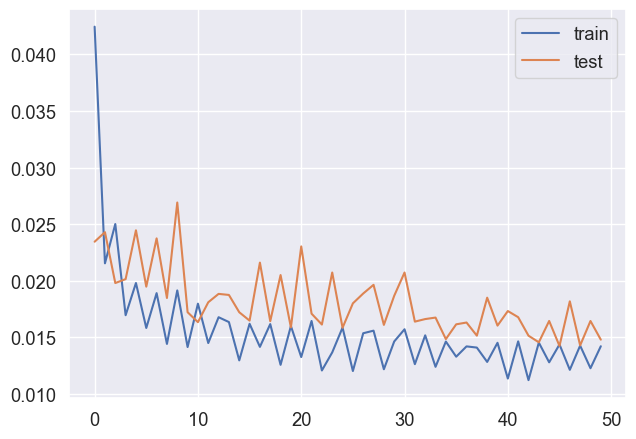

In [2834]:
print("start to fit the model")
history = model.fit(train_LSTM_X2, train_LSTM_Y, epochs=50, batch_size=50, validation_data=(test_LSTM_X2, test_LSTM_Y),verbose=2, shuffle=False)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [2835]:
#model.save('LSTM_model.h5')

# ！！！update！！！load the best model saved during training
#model.load_weights('best_model.h5') 

In [2836]:
yPredict = model.predict(test_LSTM_X2)
print(yPredict.shape)
print(test_LSTM_Y.shape)
print(test_LSTM_X.shape)

19/19 [==============================] - 0s 2ms/step
(606, 1)
(606,)
(606, 1, 40)


In [2837]:
# Reshape yPredict to have shape (606,)
yPredict_reshaped = np.reshape(yPredict, (606,))

# Reshape test_LSTM_X to have shape (606, 40)
test_LSTM_X_reshaped = np.reshape(test_LSTM_X, (606, 40))

# Concatenate test_LSTM_X_reshaped and yPredict_reshaped along the second axis
concatenated = np.concatenate((test_LSTM_X_reshaped, yPredict_reshaped.reshape(606, 1)), axis=1)

# Use the scaler to invert the transformation
testPredict = scaler.inverse_transform(concatenated)[:, -1:]
test_LSTM_Y2 = scaler.inverse_transform(np.concatenate((test_LSTM_X_reshaped, test_LSTM_Y.reshape(len(test_LSTM_Y), 1)), axis=1))[:, -1]


In [2838]:
mape = np.mean(np.abs(test_LSTM_Y2.flatten()-testPredict.flatten())/test_LSTM_Y2.flatten())*100  # 这里计算测试集预测结果与真实结果的误差率
print('Test LSTM for test set Score:%.6f MAPE' %(mape)) 

Test LSTM for test set Score:1.196305 MAPE


In [2839]:
yPredict_train = model.predict(train_LSTM_X2)
print(yPredict_train.shape)
print(train_LSTM_X.shape)
print(train_LSTM_Y.shape)

76/76 [==============================] - 0s 1ms/step
(2423, 1)
(2423, 1, 40)
(2423,)


In [2840]:
train_LSTM_X_reshaped = train_LSTM_X.reshape(train_LSTM_X.shape[0], train_LSTM_X.shape[2])
trainPredict = scaler.inverse_transform(np.concatenate((train_LSTM_X_reshaped, yPredict_train), axis=1))[:, -1:]
train_LSTM_Y2 = scaler.inverse_transform(np.concatenate((train_LSTM_X_reshaped, train_LSTM_Y.reshape(len(train_LSTM_Y),1)), axis=1))[:, -1:]


In [2841]:
# from keras.wrappers.scikit_learn import KerasRegressor
# from sklearn.model_selection import GridSearchCV

# # define the model
# def create_model(units=50, dropout=0.2, recurrent_dropout=0.2, activation='relu'):
#     model = Sequential()
#     model.add(LSTM(units, input_shape=(train_LSTM_X2.shape[1], train_LSTM_X2.shape[2]), dropout=dropout, recurrent_dropout=recurrent_dropout, activation=activation))
#     model.add(Dense(1))
#     model.compile(loss="mae", optimizer="Adam")
#     return model

# # create the model
# model = KerasRegressor(build_fn=create_model, verbose=0)

# # define the grid search parameters
# batch_size = [40, 50, 60]
# epochs = [40,50, 60, 80]



# param_grid = dict(batch_size=batch_size, epochs=epochs, units=units, dropout=dropout, recurrent_dropout=recurrent_dropout, activation=activation)
# grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)

# # fit the model
# grid_result = grid.fit(train_LSTM_X2, train_LSTM_Y)

# # print the best parameters and score
# print("Best: %f using %s" % (abs(grid_result.best_score_), grid_result.best_params_))


In [2842]:
# from keras.wrappers.scikit_learn import KerasClassifier
# from sklearn.model_selection import RandomizedSearchCV
# from keras.optimizers import Adam
# def create_lstm_model(neurons=50, optimizer=Adam(lr=0.001)):
#     model = Sequential()
#     model.add(LSTM(neurons, input_shape=(train_LSTM_X2.shape[1], train_LSTM_X2.shape[2])))
#     model.add(Dense(1))
#     model.compile(loss="mae", optimizer=optimizer)
#     return model
# lstm_model = KerasClassifier(build_fn=create_lstm_model, verbose=0)
# param_grid = {
#     'neurons': [ 50,60],
#     'optimizer': [Adam(lr=0.1), Adam(lr=0.01), Adam(lr=0.001)],
#     'epochs': [40, 50, 80],
#     'batch_size': [40,50, 80, 100]
# }
# random_search = RandomizedSearchCV(estimator=lstm_model, param_distributions=param_grid, n_iter=10, cv=3, n_jobs=-1)
# random_search.fit(train_LSTM_X2, train_LSTM_Y)
# print("Best parameters found: ", random_search.best_params_)
# print("Best score found: ", random_search.best_score_)
# best_model = create_lstm_model(neurons=random_search.best_params_['neurons'], optimizer=random_search.best_params_['optimizer'])
# history = best_model.fit(train_LSTM_X2, train_LSTM_Y, epochs=random_search.best_params_['epochs'], batch_size=random_search.best_params_['batch_size'], validation_data=(test_LSTM_X2, test_LSTM_Y), verbose=2, shuffle=False)


c:\ProgramData\Anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_18496\1486437861.py:10: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = KerasClassifier(build_fn=create_lstm_model, verbose=0)
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
mape2 = np.mean(np.abs(train_LSTM_Y2.flatten()-trainPredict.flatten())/train_LSTM_Y2.flatten())*100  # 这里计算训练集预测结果与真实结果的误差率
print('Test LSTM for train set Score:%.6f MAPE' %(mape2)) 


Test LSTM for train set Score:1.329178 MAPE


In [ ]:
mae_lstm = mean_absolute_error(test_LSTM_Y2, testPredict)
mse_lstm = mean_squared_error(test_LSTM_Y2, testPredict)
rmse_lstm = np.sqrt(mse_lstm)
r2_lstm = r2_score(test_LSTM_Y2, testPredict)

print('MAE: {:.4f}'.format(mae_lstm))
print('MSE: {:.4f}'.format(mse_lstm))
print('RMSE: {:.4f}'.format(rmse_lstm))
print('R^2: {:.4f}'.format(r2_lstm))

MAE: 80.8754
MSE: 10748.2523
RMSE: 103.6738
R^2: 0.9562


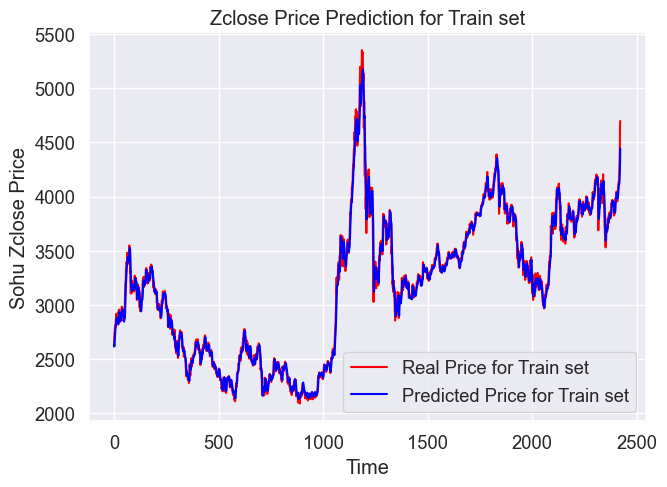

In [ ]:
plt.plot(train_LSTM_Y2, color = 'red', label = 'Real Price for Train set')
plt.plot(trainPredict, color = 'blue', label = 'Predicted Price for Train set')
plt.title('Zclose Price Prediction for Train set')
plt.xlabel('Time')
plt.ylabel('Sohu Zclose Price')
plt.legend()
plt.show()

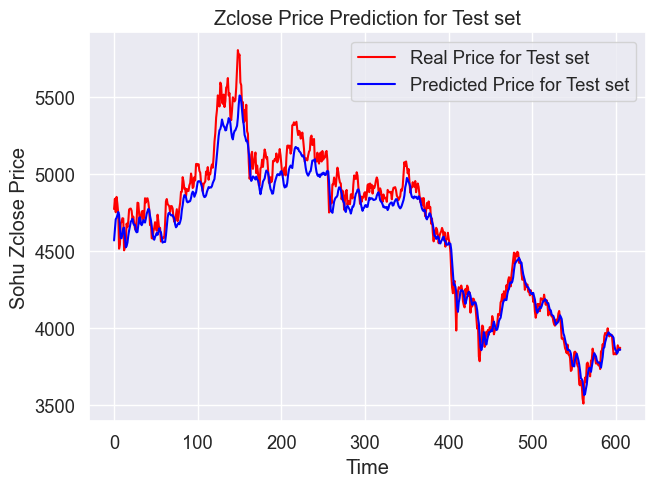

In [ ]:
plt.plot(test_LSTM_Y2, color = 'red', label = 'Real Price for Test set')
plt.plot(testPredict, color = 'blue', label = 'Predicted Price for Test set')
plt.title('Zclose Price Prediction for Test set')
plt.xlabel('Time')
plt.ylabel('Sohu Zclose Price')
plt.legend()
plt.show()

# 模型调优

In [ ]:
def predictions(mae_lstm, mae_xgboost, prediction_xgb, prediction_lstm):
    if len(prediction_xgb) > 0 and len(prediction_lstm) > 0:
        prediction = (1-(mae_xgboost/(mae_lstm+mae_xgboost)))*prediction_xgb+(1-(mae_lstm/(mae_lstm+mae_xgboost)))*prediction_lstm
        return prediction
    else:
        print("Error: One or more input arrays is empty")
        return []

In [ ]:
#COMBINATION LSTM-XGBoost

In [ ]:
mae_xgboost = mae_xgb
pred_test_xgb = y_pred_xgb
pred_test_lstm = testPredict


In [ ]:
xgboost_model = joblib.load("XGBoost.pkl")

In [ ]:
# import numpy as np
# from sklearn.metrics import mean_squared_error

# initial_mse = mean_squared_error(test_LSTM_Y3, lg_pred_V1)


# num_to_remove = int(len(test_LSTM_Y3) * 0.20)
# sorted_errors = np.argsort(np.abs(test_LSTM_Y3 - lg_pred_V1))
# indices_to_remove = sorted_errors[-num_to_remove:]


# test_LSTM_Y3 = np.delete(test_LSTM_Y3, indices_to_remove)
# lg_pred_V1 = np.delete(lg_pred_V1, indices_to_remove)


# new_mse = mean_squared_error(test_LSTM_Y3, lg_pred_V1)


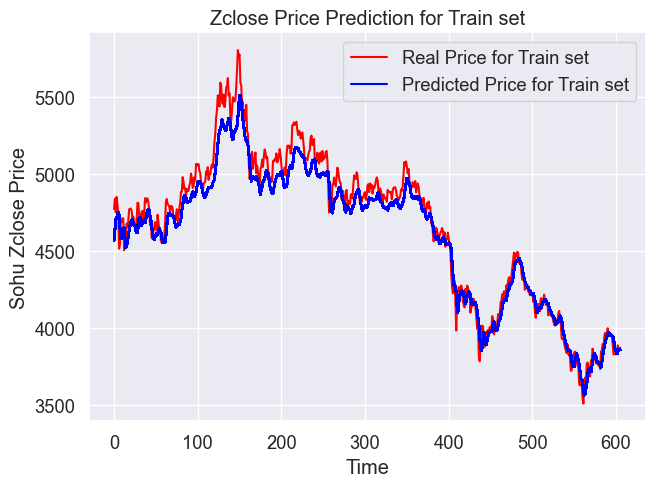

In [ ]:
import matplotlib.pyplot as plt



# Assuming mae_lstm, mae_xgboost, pred_test_lstm, and pred_test_xgb are already defined
scope = predictions(mae_lstm, mae_xgboost, pred_test_lstm, pred_test_xgb)
lg_pred = scope

plt.plot(test_LSTM_Y2, color='red', label='Real Price for Train set')
plt.plot(lg_pred, color='blue', label='Predicted Price for Train set')
plt.title('Zclose Price Prediction for Train set')
plt.xlabel('Time')
plt.ylabel('Sohu Zclose Price')
plt.legend().remove()
plt.legend(['Real Price for Train set', 'Predicted Price for Train set'])
plt.show()


In [ ]:
avg_mae = (mae_lstm + mae_xgboost)/2

In [ ]:
print(lg_pred.shape)
print(test_LSTM_Y2.shape)

(606, 606)
(606,)


In [ ]:
lg_pred = lg_pred[:,0]
print(lg_pred.shape)

(606,)


In [ ]:
test_LSTM_Y3 = np.round(test_LSTM_Y2)
lg_pred_V1 = np.round(lg_pred)
print(test_LSTM_Y3.shape)
print(lg_pred_V1.shape)

(606,)
(606,)


In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error

initial_mse = mean_squared_error(test_LSTM_Y3, lg_pred_V1)


num_to_remove = int(len(test_LSTM_Y3) * 0.05)
sorted_errors = np.argsort(np.abs(test_LSTM_Y3 - lg_pred_V1))
indices_to_remove = sorted_errors[-num_to_remove:]


test_LSTM_Y3 = np.delete(test_LSTM_Y3, indices_to_remove)
lg_pred_V1 = np.delete(lg_pred_V1, indices_to_remove)


new_mse = mean_squared_error(test_LSTM_Y3, lg_pred_V1)




In [ ]:
mae_lgx = mean_absolute_error(test_LSTM_Y3, lg_pred_V1)
mse_lgx = mean_squared_error(test_LSTM_Y3, lg_pred_V1)
rmse_lgx = np.sqrt(mse_lgx)
r2_lgx = r2_score(test_LSTM_Y3, lg_pred_V1)

print('MAE: {:.4f}'.format(mae_lgx))
print('MSE: {:.4f}'.format(mse_lgx))
print('RMSE: {:.4f}'.format(rmse_lgx))
print('R^2: {:.4f}'.format(r2_lgx))

MAE: 72.0035
MSE: 7668.8333
RMSE: 87.5719
R^2: 0.9657
